# Automatic Question Answering from FAQ using word embeddings

In this notebook we examine the task of automatically retrieving a suitable response to customer questions from FAQs. Often websites have comprehensive FAQs, but manually searching and finding the answer to a specific question from these FAQs is not trivial. The purpose of this exercise is to answer user queries by automatically retrieving the closest question and answer from predefined FAQs when appropriate. 

We will use a sample dataset of FAQs extracted from the site https://machinelearninginterview.com for this task. This dataset can be replaced with a more elaborate dataset as appropriate.

Our basic strategy is as follows: For a given query, find the FAQ question that is closest in meaning to the user query and display it to the user. For this, we need to have an efficient way of computing **semantic similarity** between two sentances. 

To compute sementic similarity between sentences, we will convert each sentence into a vector. We can then use cosine similarity between vectors to come up with a distance measure between sentences that indicates how similar they are in meaning.

We will now learn how to go about this. 


**Installation and setup**

You need to install the following packages. Most are specified in conda except for bert-serving-server and  bert-serving-client These are required to experiment with bert embeddings) that are not in the conda repository and need to be installed through pip.

#Numpy,  scikit-learn need to be installed
conda install gensim
conda install nltk

conda install tensorflow=1.13

pip install bert-serving-server
pip install bert-serving-client

You need to start the BERT server as follows to get phrase embeddings using bert.

bert-serving-start -model_dir /tmp/english_L-12_H-768_A-12/ -num_worker=1 &

Now let us get started:



In [28]:
import pandas as pd;

#Load dataset and examine dataset, rename columns to questions and answers

df=pd.read_csv("FAQ_MachineLearningInterview_com.csv");
df.columns=["questions","answers"];

df

,questions,answers
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,..."
2,What’s the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...
7,What is the mathematical background required t...,The following three are the basic building blo...
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da..."


# Preprocessing 

Most NLP tasks involve preprocessing. For this task we are performing the following preprocessing : 
1. Removing all characters that are not alpha numeric
2. Removing stopwords - commonly used words such as 'a', 'to', 'in' and so on.. that do not contribute to the semantic similarity between two sentences.

We apply this to both the FAQ questions and the user query sentence.

Note that we have an option to not perform stopword removal. This is because some of the later models such as BERT work well without stopword removal - and we will try that out.

In [29]:

import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

#from nltk.stem.lancaster import LancasterStemmer
#st = LancasterStemmer()

def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
    #sentence = re.sub(r'\s{2,}', ' ', sentence)
    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    #sent_stemmed='';
    #for word in sentence.split():
    #    sent_stemmed+=' '+st.stem(word) 
    #sentence=sent_stemmed
    
    return sentence
                    
def get_cleaned_sentences(df,stopwords=False):    
    sents=df[["questions"]];
    cleaned_sentences=[]

    for index,row in df.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
print(cleaned_sentences);

print("\n")

cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
print(cleaned_sentences_with_stopwords);
    

['job hunting experience look like', 'insights offer ds job market', 'whats impact covid hiring ds roles', 'skills qualities employers look data scientist', 'employers look advanced ml degree', 'typical day data scientist look like', 'preparation algorithms data structures needed data science interview', 'mathematical background required data scientist', 'rounds data scientist interview', 'level proficiency needed data scientist coding']


['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 

# Bag of words Model

The first model we will use for semantic similarity is leveraging Bag of Words (BOW). With BOW, each sentence is encoded into a vector whose length is the number of words in the vocabulary. Each element of the vector indicates how many times the particular word occurs in the sentence. An example is shown below by printing the dictionary and the FAQ questions in the BOW sparse format.

Note that a vector representation of a sentence is often also called an "Embedding" since it is a way of embedding a sentence in M-dimensional space if the vector is of length M.    

In [30]:
import numpy

sentences=cleaned_sentences_with_stopwords
#sentences=cleaned_sentences

# Split it by white space 
sentence_words = [[word for word in document.split() ]
         for document in sentences]

from gensim import corpora

dictionary = corpora.Dictionary(sentence_words)
for key, value in dictionary.items():
    print(key, ' : ', value)

import pprint
bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]
for sent,embedding in zip(sentences,bow_corpus):
    print(sent)
    print(embedding)

#question_orig="do I need to learn algorithms to be a data scientist ?";
question_orig="What does a data scientist usually do ?"
question=clean_sentence(question_orig,stopwords=False);
question_embedding = dictionary.doc2bow(question.split())


print("\n\n",question,"\n",question_embedding)

0  :  does
1  :  experience
2  :  hunting
3  :  job
4  :  like
5  :  look
6  :  the
7  :  what
8  :  about
9  :  any
10  :  can
11  :  ds
12  :  insights
13  :  market
14  :  offer
15  :  you
16  :  covid
17  :  for
18  :  hiring
19  :  impact
20  :  of
21  :  on
22  :  roles
23  :  whats
24  :  a
25  :  and
26  :  data
27  :  do
28  :  employers
29  :  in
30  :  qualities
31  :  scientist
32  :  skills
33  :  advanced
34  :  an
35  :  degree
36  :  ml
37  :  day
38  :  how
39  :  typical
40  :  algorithms
41  :  interview
42  :  is
43  :  needed
44  :  preparation
45  :  science
46  :  structures
47  :  background
48  :  be
49  :  mathematical
50  :  required
51  :  to
52  :  are
53  :  rounds
54  :  various
55  :  coding
56  :  level
57  :  proficiency
what does the job hunting experience look like 
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
any insights you can offer about the ds job market 
[(3, 1), (6, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (

Once we find a vector representation for each sentence using BOW,we can compute the distance between two vectors by taking the cosine similarity. Note other similarity measure can be used as well, but we will stick to cosine similarity throughout for simplicity.

The closest matching answer can be retrieved by finding the cosine similarity of the query vector with each of the FAQ question vectors. 

We see that in the example below, BOW representation did not do very well and retrieved the wrong answer since it is looking for exact word match. For instance the word "learn" in the query is similar to "prepare" in "Do we need to prepare algorithms and data structures for data science interview?". However BOW cannot figure this out.  

In [31]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        #sim=cosine_similarity(embedding.reshape(1, -1),question_embedding.reshape(1, -1))[0][0];
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        print(index, sim, sentences[index])
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
       
    print("\n")
    print("Question: ",question)
    print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    print(FAQdf.iloc[index_sim,1])        
    
retrieveAndPrintFAQAnswer(question_embedding,bow_corpus,df,sentences);

0 1.0 what does the job hunting experience look like 
1 0.31622776601683794 any insights you can offer about the ds job market 
2 0.1643989873053573 whats the impact of covid on hiring for ds roles
3 0.19611613513818404 what skills and qualities do employers look for in a data scientist
4 0.19611613513818404 do employers look for an advanced ml degree
5 1.0 how does a typical day of a data scientist look like
6 0.058722021951470346 is preparation of algorithms and data structures needed for a data science interview 
7 0.1643989873053573 what is the mathematical background required to be a data scientist 
8 0.1643989873053573 what are the various rounds in a data scientist interview 
9 0.1414213562373095 what level of proficiency is needed for a data scientist in coding


Question:  what does a data scientist usually do 


Retrieved:  What does the job hunting experience look like ?
Job hunting experience involves networking to get in touch with the right people in various companies, ap

# Word2Vec Embeddings

Word2Vec ebeddings are popularly trained using the skipgram model. These embeddings are trained to take a word as input and reconstruct its context. As a result, they are able to take into account semantic similarity of words based  on context information. The resulting embeddings are such that words with similar meaning tend to be closer in terms of cosine similarity. 

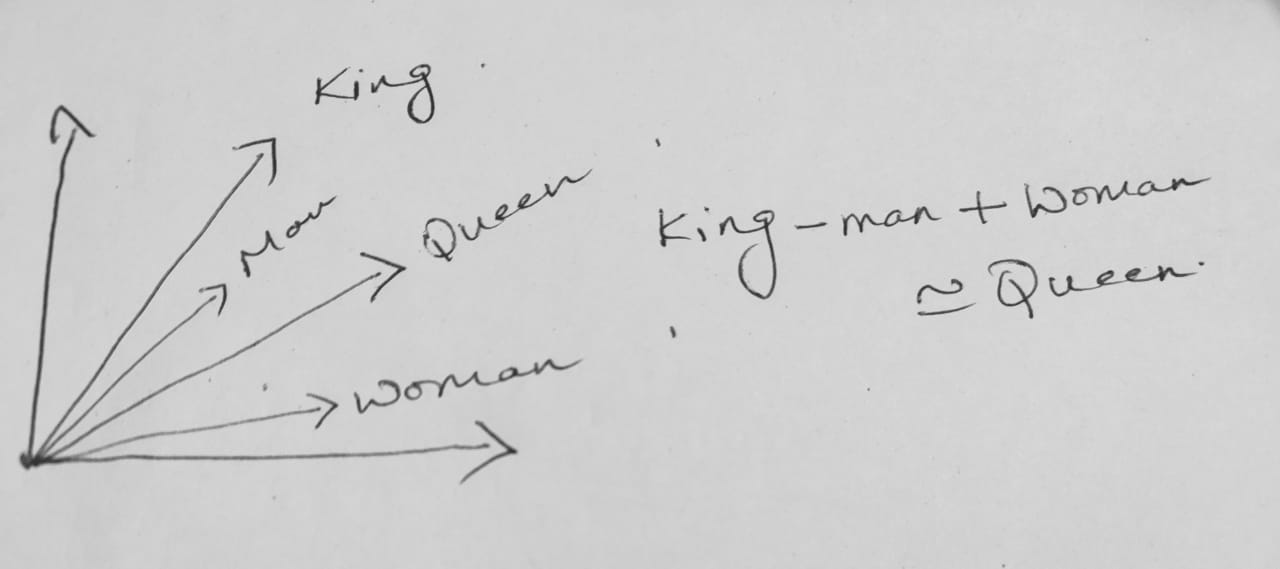





**Skipgram model** : 

The most popular word2vec model is the skipgram model. Particularly, the most commonly used pre-trained model is based on the Google News dataset that has 3 billion running words and creates upto 300 dimensional embedding for 3 Million words

You can find more information on the following page : https://code.google.com/archive/p/word2vec/

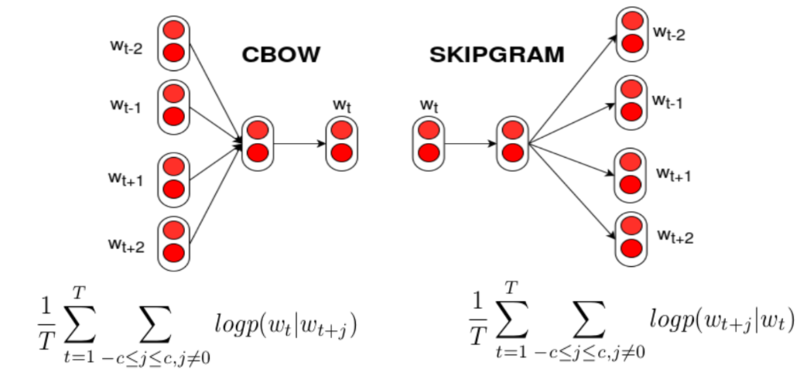

# Glove Embeddings : 

Glove is an alternate approach to build word embeddings using matrix factorization techinques on the word-word co-occurance matrix. 

https://nlp.stanford.edu/projects/glove/

While both the techniques are popular, glove performs better on some datasets while word2vec skipgram model performs better on some. Here, we experiment with both the word2vec and the glove models. 


In [5]:
from gensim.models import Word2Vec 
import gensim.downloader as api


glove_model=None;
try:
    glove_model = gensim.models.KeyedVectors.load("./glovemodel.mod")
    print("Loaded glove model")
except:            
    glove_model = api.load('glove-twitter-25')
    glove_model.save("./glovemodel.mod")
    print("Saved glove model")
    
v2w_model=None;
try:
    v2w_model = gensim.models.KeyedVectors.load("./w2vecmodel.mod")
    print("Loaded w2v model")
except:            
    v2w_model = api.load('word2vec-google-news-300')
    v2w_model.save("./w2vecmodel.mod")
    print("Saved glove model")

w2vec_embedding_size=len(v2w_model['computer']);
glove_embedding_size=len(glove_model['computer']);


Loaded glove model
Loaded w2v model


**Finding Phrase Embeddings from Word Embeddings** 

To find phrase embeddings, there are sevaral specialized techniques. The most simple technique to convert word embeddings to phrase embeddings, that is applicable with word2vec and glove embeddings, is to sum up the individual word embeddings in the phrase to get a phrase vector. 

This is implemented below.


In [34]:
def getWordVec(word,model):
        samp=model['computer'];
        vec=[0]*len(samp);
        try:
                vec=model[word];
        except:
                vec=[0]*len(samp);
        return (vec)


def getPhraseEmbedding(phrase,embeddingmodel):
                       
        samp=getWordVec('computer', embeddingmodel);
        vec=numpy.array([0]*len(samp));
        den=0;
        for word in phrase.split():
            #print(word)
            den=den+1;
            vec=vec+numpy.array(getWordVec(word,embeddingmodel));
        #vec=vec/den;
        #return (vec.tolist());
        return vec.reshape(1, -1)


In [35]:
#With w2Vec

sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

question_embedding=getPhraseEmbedding(question,v2w_model);

retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);

0 0.42883351712089046 job hunting experience look like
1 0.339002381090381 insights offer ds job market
2 0.29925527320308326 whats impact covid hiring ds roles
3 0.5991923709091538 skills qualities employers look data scientist
4 0.2836109001421266 employers look advanced ml degree
5 0.7728937373489242 typical day data scientist look like
6 0.6020050170744115 preparation algorithms data structures needed data science interview
7 0.6440332904913528 mathematical background required data scientist
8 0.5696568380249729 rounds data scientist interview
9 0.5920593804800893 level proficiency needed data scientist coding


Question:  what does a data scientist usually do 


Retrieved:  How does a typical day of a data scientist look like?
Here are some tasks in the typical day of a data scientist:

Make a plan for the day
Look at data, what clean up is required, figure out what models can be built
Talk to various stakeholders about what modeling is possible and help them narrow down to someth

In [36]:
#With Glove

sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,glove_model));
    
question_embedding=getPhraseEmbedding(question,glove_model);

retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);


0 0.9206842895542598 job hunting experience look like
1 0.774016663828011 insights offer ds job market
2 0.8574905678154826 whats impact covid hiring ds roles
3 0.8762150927509162 skills qualities employers look data scientist
4 0.8210408780157619 employers look advanced ml degree
5 0.9545922769035373 typical day data scientist look like
6 0.800442887059875 preparation algorithms data structures needed data science interview
7 0.7939550540301473 mathematical background required data scientist
8 0.8481202624655192 rounds data scientist interview
9 0.7833404988245979 level proficiency needed data scientist coding


Question:  what does a data scientist usually do 


Retrieved:  How does a typical day of a data scientist look like?
Here are some tasks in the typical day of a data scientist:

Make a plan for the day
Look at data, what clean up is required, figure out what models can be built
Talk to various stakeholders about what modeling is possible and help them narrow down to something

# BERT EMBEDDINGS


https://www.blog.google/products/search/search-language-understanding-bert/

Instead of looking at words in isolation, BERT, a transformer based model attempts to use the context of words to get embeddings. BERT broke severarl records in NLP tasks in 2018, a huge leap in NLP. BERT uses several concepts in deep learning to come up with a model that looks at context in a bi-directional fashion, leveraging information from the entire sentence as a whole through self-attention. Take a look at https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/ for more information on BERT. 

The following search query is a good way to understand BERT: “2019 brazil traveler to usa need a visa,”. We observe that the relationship of the word “to” to other words in the sentence are important to decode the meaning semantically. Returning information about U.S. citizens traveling to Brazil is not really relevant since we are taking about Brazil citizens travelling to USA. This is something that BERT is able to handle well. See the example below. 

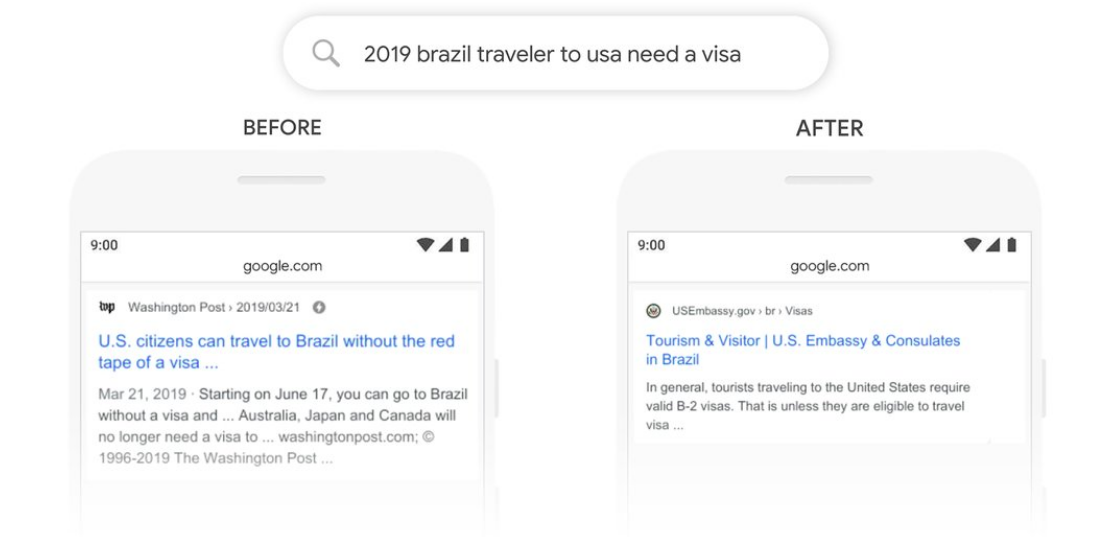

Another popular example is how BERT can understand the "no" qualifier in comparison to other models. For instance, with the query "Parking on a hill with no curb",  it is not useful to show results for parking on a hill with a curb even though it is semantically close. BERT can make this subtle distinction.

Unlike some of the earlier models we have used, with BERT, you might not need to remove some of the stop words that you would otherwise remove when you used bag of words of word to vec. We will see this in the exercise below as well. 

Since custom training a BERT model is beyond the scope of this article, we will use the the following package to get the embedding of a phrase using BERT 
https://pypi.org/project/bert-embedding/

In [37]:
from bert_serving.client import BertClient
bc = BertClient()
res=bc.encode(['ML', 'AI'])

In [38]:
question=clean_sentence(question_orig,stopwords=False);
cleaned_sentences=get_cleaned_sentences(df,stopwords=False)

sent_bertphrase_embeddings=[];
for sent in cleaned_sentences:
    sent_bertphrase_embeddings.append(bc.encode([sent]));
    
question_embedding=bc.encode([question]);

retrieveAndPrintFAQAnswer(question_embedding,sent_bertphrase_embeddings,df, cleaned_sentences);

0 0.84057343 what does the job hunting experience look like 
1 0.722398 any insights you can offer about the ds job market 
2 0.70140886 whats the impact of covid on hiring for ds roles
3 0.8119571 what skills and qualities do employers look for in a data scientist
4 0.7749537 do employers look for an advanced ml degree
5 0.86003697 how does a typical day of a data scientist look like
6 0.7659602 is preparation of algorithms and data structures needed for a data science interview 
7 0.8592837 what is the mathematical background required to be a data scientist 
8 0.84925056 what are the various rounds in a data scientist interview 
9 0.82339096 what level of proficiency is needed for a data scientist in coding


Question:  what does a data scientist usually do 


Retrieved:  How does a typical day of a data scientist look like?
Here are some tasks in the typical day of a data scientist:

Make a plan for the day
Look at data, what clean up is required, figure out what models can be built

**Trying a new query with stopwords=False and stopwords=True**

In [40]:
#With BOW, word2Vec and BERT with stopwords removed
question_new="Is it required to have background in  algorithms and complexity for data scientist roles"
#question=clean_sentence("Is algorithms and complexity required for a data science role  ?",stopwords=True);

question=clean_sentence(question_new,stopwords=True);
cleaned_sentences=get_cleaned_sentences(df,stopwords=True)

#Try  BOW
#question_embedding = dictionary.doc2bow(question.lower().split())
#print("\n\n With BOW\n\n")
#retrieveAndPrintFAQAnswer(question_embedding,bow_corpus,df);

sent_embeddings=[];
for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent,v2w_model));

question_embedding=getPhraseEmbedding(question,v2w_model);

print("\n With Word2Vec\n\n")
retrieveAndPrintFAQAnswer(question_embedding,sent_embeddings,df, cleaned_sentences);

question=clean_sentence(question_new,stopwords=False);
cleaned_sentences=get_cleaned_sentences(df,stopwords=False)

sent_bertphrase_embeddings=[];
for sent in cleaned_sentences:
    sent_bertphrase_embeddings.append(bc.encode([sent]));
    
question_embedding=bc.encode([question]);

print("\n\n With BERT\n\n")
retrieveAndPrintFAQAnswer(question_embedding,sent_bertphrase_embeddings,df, cleaned_sentences);


 With Word2Vec


0 0.5094725018537826 what does the job hunting experience look like 
1 0.5586288478466148 any insights you can offer about the ds job market 
2 0.5255742688379702 whats the impact of covid on hiring for ds roles
3 0.7059507852613247 what skills and qualities do employers look for in a data scientist
4 0.514141274655577 do employers look for an advanced ml degree
5 0.6553978512687986 how does a typical day of a data scientist look like
6 0.7808408423411823 is preparation of algorithms and data structures needed for a data science interview 
7 0.8538397386109996 what is the mathematical background required to be a data scientist 
8 0.6355760046092597 what are the various rounds in a data scientist interview 
9 0.8013590009860398 what level of proficiency is needed for a data scientist in coding


Question:  is it required to have background in  algorithms and complexity for data scientist roles


Retrieved:  What is the mathematical background required to be a data scie